# Base dos Dados Python 102

**TL;DR:** Neste artigo vamos demonstrar como acessar os dados do BD+ via consulta SQL pelo pacote da Base Dos Dados em Python. Em seguida vamos continuar as análises do post [Base Dos Dados Python 101](https://dev.to/basedosdados/base-dos-dados-python-101-3l6-temp-slug-495353), sobre a popularidade de nomes nos estados brasileiros, com o conteúdo adaptado do [Workshop "Brincando com dados da BD+ em Python"](https://www.youtube.com/watch?v=wI2xEioDPgM).

In [1]:
import pandas as pd
import geopandas as gpd
import basedosdados as bd
import matplotlib.pyplot as plt

## Consultas SQL na BD+

Já vimos em um artigo anterior que podemos acessar a BD+ pela função `read_table`, capaz de carregar uma tabela por vez. Hoje vamos acessar a BD+ por meio de consultas SQL, com a função `read_sql`. Recomendamos essa opção, por contar com toda a capacidade da linguagem SQL, acesso amplo ao acervo da BD+ e retorno em formato de dataframe. Além do mais, sua sintaxe é análoga a `read_table`. Isto é, precisamos apenas fornecer uma consulta válida e um id de projeto do Google Cloud.

A seguir ilustramos uma consulta de dados da tabela de nomes brasileiros do IBGE (2010) cruzada com diretórios brasileiros, com fim de obter o nome mais popular de cada estado. Observe que precisamos fornecer o nome do datalake (basedosdados), dataset (br_bd_diretorios_brasil) e tabela (municipio).

In [2]:
df = bd.read_sql(
    '''
    SELECT estado.uf AS state, estado.municipio AS town, nomes.nome AS name, nomes.qtde_nascimentos_ate_2010 AS freq
    FROM  basedosdados.br_ibge_nomes_brasil.quantidade_municipio_nome_2010 AS nomes
    INNER JOIN basedosdados.br_bd_diretorios_brasil.municipio AS estado ON nomes.id_municipio = estado.id_municipio
    ''',
    billing_project_id='basedosdados42'
)

Downloading: 100%|█████████████████████████████████████████████████████| 1959116/1959116 [00:08<00:00, 225834.10rows/s]


Após lermos os dados realizamos um pré-processamento. Neste processo, eliminamos nomes únicos ou erros em municípios, como: Awo, Yorane e Zilneide. Por fim, também calculamos a frequência dos nomes nos estados por 100.000 pessoas.

In [3]:
df = df[df.duplicated('name', keep=False)] # seleciona nomes que aparecem mais de uma vez

total_by_state = df.groupby('state').freq.sum() # agrupa o total por estado
df = df.merge(total_by_state, on='state', suffixes=('', '_total_by_state')) # une os dados com total por estado

df['freq_per_100k'] = 100_000 * df.freq / df.freq_total_by_state # cria o total por estado por 100k pessoas

## Em que estado Fred é mais famoso?

Nossa primeira questão de análise é descobrir como está distribuída a frequência de um nome nos estados brasileiros. Em particular gostaríamos de saber em qual estado Fred, nome de um de nossos desenvolvedores, é o nome mais famoso. Então vamos contar a frequência do nome Fred por 100.000 pessoas em cada estado, e em seguida representar este dado com um mapa com gradiente de cores (coroplético). 

Para isso, previamente instalamos a biblioteca `geopandas` para auxiliar o desenho do mapa e manualmente criamos um mapeamento entre o nome de um estado e sua abreviação nos dados geográficos `state2abbr`.

In [4]:
state2abbr = {
    'Acre': 'BR.AC', 'Alagoas': 'BR.AL', 'Amapá': 'BR.AP',
    'Amazonas': 'BR.AM', 'Bahia': 'BR.BA', 'Ceará': 'BR.CE',
    'Distrito Federal': 'BR.DF', 'Espírito Santo': 'BR.ES',
    'Goiás': 'BR.GO', 'Maranhão': 'BR.MA', 'Mato Grosso': 'BR.MT',
    'Mato Grosso do Sul': 'BR.MS', 'Minas Gerais': 'BR.MG',
    'Pará': 'BR.PA', 'Paraíba': 'BR.PB', 'Paraná': 'BR.PR',
    'Pernambuco': 'BR.PE', 'Piauí': 'BR.PI', 'Rio de Janeiro': 'BR.RJ',
    'Rio Grande do Norte': 'BR.RN', 'Rio Grande do Sul': 'BR.RS',
    'Rondônia': 'BR.RO', 'Roraima': 'BR.RR', 'Santa Catarina': 'BR.SC',
    'São Paulo': 'BR.SP', 'Sergipe': 'BR.SE', 'Tocantins': 'BR.TO',
}

Em seguida criamos a função `visualize_name` que filtra os dados do nome, agrupa a frequência por estados e desenha o mapa.

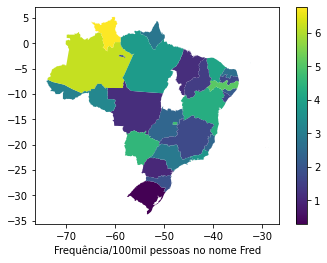

In [5]:
def visualize_name(df, name):
    name_df = df.query(f'name == "{name}"') # filtra o nome escolhido
    name_df = name_df.groupby('state', as_index=False).sum() # agrupa pelos estados
    name_df.state = name_df.state.apply(lambda x: state2abbr[x]) # abrevia os estados
    name_df = name_df.rename(columns={'state': 'HASC_1'}) # renomeia a coluna
    
    fig, ax = plt.subplots(1, 1)
    br_map = gpd.read_file('./shapes/gadm36_BRA_1.shp') # lê o mapa
    br_map = br_map.merge(name_df, on='HASC_1', how='outer') # une o mapa com os dados
    br_map.plot(column='freq_per_100k', ax=ax, legend=True) # desenha o gráfico
    plt.xlabel('Frequência/100mil pessoas no nome Fred')
    plt.savefig('fred_freq')

visualize_name(df, 'Fred')

Interessante notar como Fred parece um nome comum em estados como Amazonas e Roraima, devido a população nestes estados ser menor quando comparada com São Paulo.

In [6]:
print('Qtde em Roraima:', df.query('name == "Fred" & state == "Roraima"').freq.sum())
print('Qtde em São Paulo:', df.query('name == "Fred" & state == "São Paulo"').freq.sum())

Qtde em Roraima: 19
Qtde em São Paulo: 1012


In [7]:
print('Freq/100k em Roraima:', df.query('name == "Fred" & state == "Roraima"').freq_per_100k.sum())
print('Freq/100k em São Paulo:', df.query('name == "Fred" & state == "São Paulo"').freq_per_100k.sum())

Freq/100k em Roraima: 6.782662087774787
Freq/100k em São Paulo: 2.9175647836323


## Quais são os nomes mais regionais?

Essa é uma boa pergunta a se fazer: qual nome é mais exclusivo de uma região? Ou seja, é mais provável de ser encontrado numa determinada região e não em outros estados.

Vamos solucionar esta dúvida agrupando a frequência de nomes dos municípios em estados. Em seguida excluímos os nomes que aparecem apenas em um estado. Para então calcular a mediana e desvio padrão das frequências de cada nome distinto, e por fim normalizamos as frequências de nomes.

In [8]:
state_df = df.groupby(['name', 'state'], as_index=False).sum() # soma as frequências de municípios
state_df = state_df[state_df.duplicated('name', keep=False)] # elimina nomes não duplicados

median = state_df.groupby('name', as_index=False).freq_per_100k.median()
state_df = state_df.merge(median, on='name', suffixes=('', '_median'))

std = state_df.groupby('name', as_index=False).freq_per_100k.std()
state_df = state_df.merge(std, on='name', suffixes=('', '_std'))

state_df['freq_per_100k_zscore'] = state_df.freq_per_100k
state_df['freq_per_100k_zscore'] -= state_df.freq_per_100k_median
state_df['freq_per_100k_zscore'] /= state_df.freq_per_100k_std

Podemos então visualizar quais são os nomes mais regionais, procurando pela máxima frequência normalizada de cada estado.

In [9]:
idxmax = state_df[['state', 'freq_per_100k_zscore']].groupby('state').idxmax()
idxmax = idxmax.values.ravel()

max_name_by_state = state_df.loc[idxmax][['state', 'name', 'freq_per_100k_zscore']]
max_name_by_state = max_name_by_state.sort_values(by='state').set_index('state')

Para aprender como funciona, nada melhor que brincar com o código. Agora é com você!! Como ficou seu nome no ranking? Em qual estado aparece com maior frequência? Fez uma análise da sua família e descobriu alguma coisa legal? Conta pra gente no twitter!

---

**Confira o notebook com a análise completa no nosso [repositório](https://github.com/basedosdados/analises)**

Texto produzido por [Vinicius](https://github.com/vncsna), [Fernanda](https://github.com/fernandascovino) e Paolo, da Base dos Dados 💚